> The barchart visualization code was written by Babatunde Olaniyi **@tunescobabs**


In [6]:
convo_folder = r'C:\Users\user\Downloads\chat_gpt_history'
local_tz = 'Europe/London' 

In [7]:
import json

with open(f'{convo_folder}/conversations.json', 'r') as f:
    oai_convs = json.load(f)

In [8]:
from datetime import datetime, timezone, timedelta

oai_convo_times = []
for conv in oai_convs:
    # Given Unix timestamp
    unix_timestamp = conv['create_time']

    # Convert to UTC datetime
    utc_datetime = datetime.fromtimestamp(unix_timestamp, tz=timezone.utc)

    # Convert UTC datetime to local timezone
    pt_datetime = utc_datetime.astimezone(pytz.timezone(local_tz))
    oai_convo_times.append(pt_datetime)

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

def create_year_heatmap(convo_times, year):
    # Convert convo_times to dates and filter for the given year
    just_dates = [convo.date() for convo in convo_times if convo.year == year]

    date_counts = Counter(just_dates)

    # Create a full year date range for the calendar
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()

    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]

    # Prepare data for plotting
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = date_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1

    # Plot the heatmap
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    max_count_date = max(date_counts, key=date_counts.get)
    max_count = date_counts[max_count_date]
    p90_count = np.percentile(list(date_counts.values()), 90)
    for week, day_of_week, count in data:
        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    # Replace week numbers with month names below the heatmap
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                    if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    # Adjustments for readability
    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(
        f'{year} ChatGPT Conversation Heatmap (total={sum(date_counts.values())}).\nMost active day: {max_count_date} with {max_count} convos.',
        fontsize=16
    )
    plt.xticks([])
    plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.gca().invert_yaxis()
    plt.show()

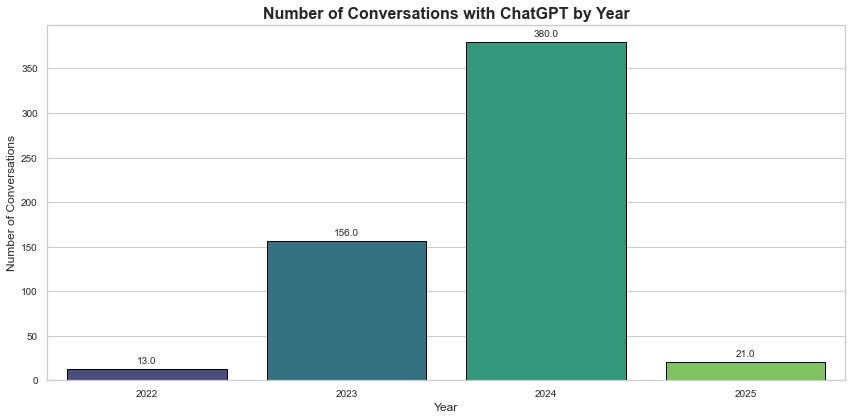

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Extract years from conversation times
years = [convo.year for convo in oai_convo_times]

# Count the number of conversations per year
year_counts = Counter(years)

# Prepare data for plotting
sorted_years = sorted(year_counts.keys())
counts = [year_counts[year] for year in sorted_years]

# Create a DataFrame for Seaborn
import pandas as pd
data = pd.DataFrame({'Year': sorted_years, 'Conversations': counts})

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(12, 6))
palette = sns.color_palette("viridis", len(sorted_years))  # Use a vibrant color palette
barplot = sns.barplot(
    x='Year',
    y='Conversations',
    data=data,
    palette=palette,
    edgecolor='black'
)

# Add value labels to the bars
for bar in barplot.patches:
    barplot.annotate(
        format(bar.get_height(), ','),  
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='center',
        size=10,
        xytext=(0, 8),
        textcoords='offset points'
    )

# Customize the chart
plt.title('Number of Conversations with ChatGPT by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Conversations', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the chart
plt.show()
